In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import os
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
import time
from tqdm import tqdm
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import featuretools as ft
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
import gc
import dask.dataframe as dd

In [6]:
df_triage_path = ('../tesisaustral/df_triage_ok.csv')
df_triage = pd.read_csv(df_triage_path)

In [7]:
print(df_triage.shape)

(560486, 543)



Columnas con más del 5% de valores nulos:
absolutamentemphcitocuenta_ultimo             61.118387
albumina_ultima                               80.100484
anc(absneutrophilcuenta)_ultimo               60.711240
aniongap_ultimo                               62.264713
aspartatoaminotransferasa(ast)_ultimo         78.062075
b-typenatriureticpeptidepro(probnp)_ultimo    98.053653
bilirrubinadirect_ultimo                      90.134812
panecillo_ultimo                              62.020104
bollo/creatratio_ultimo                       70.275618
calcio_ultimo                                 61.783345
cloruro_ultimo                                62.006009
creatinina_ultimo                             62.016714
dimero_d_ultimo                               98.289342
egfr_ultimo                                   98.480961
glucosa_ultima                                62.048115
hematocrito_ultimo                            60.232370
hemoglobina_ultima                            60.246108
inr_u

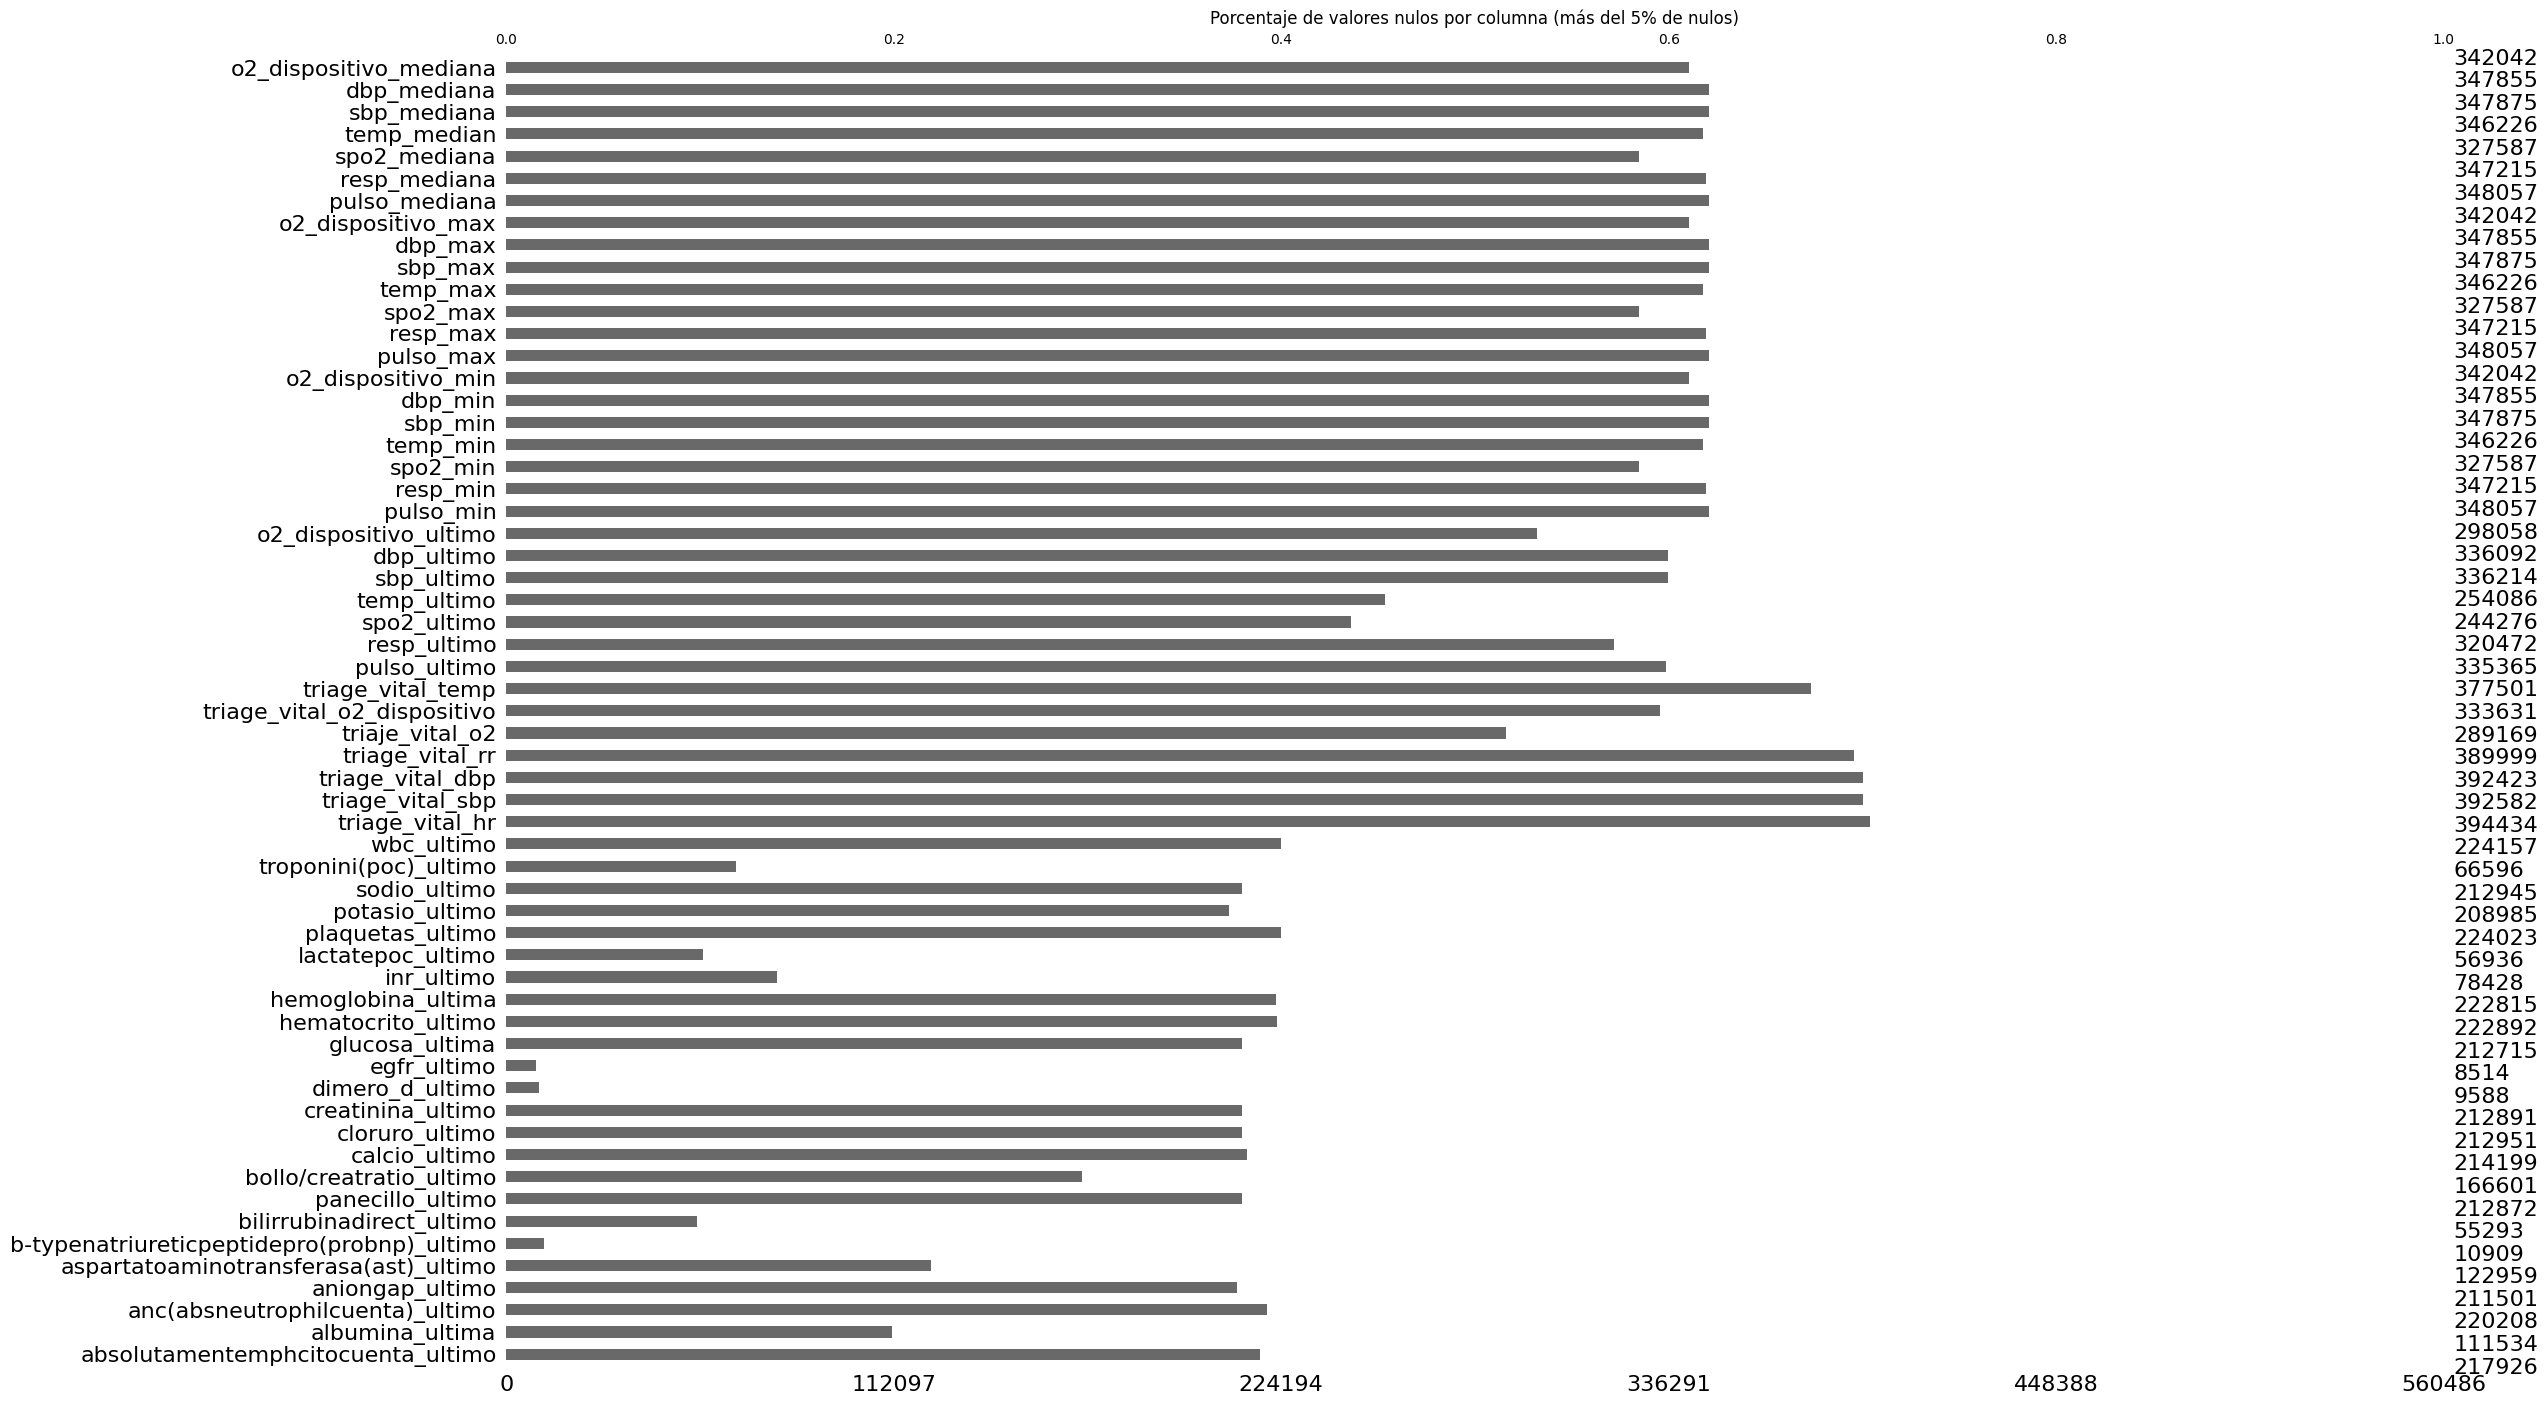

In [8]:
# Contar los valores nulos en cada columna
na_counts = df_triage.isnull().sum()

# Calcular el porcentaje de valores nulos por columna
na_percentage = (na_counts / len(df_triage)) * 100

# Filtrar las columnas que tienen más del 5% de valores nulos
na_columns_5_percent = na_percentage[na_percentage > 5]
print("\nColumnas con más del 5% de valores nulos:")
print(na_columns_5_percent)

# Contar el número de columnas con más del 5% de valores nulos
print("\nNúmero de columnas con más del 5% de valores nulos:")
print(len(na_columns_5_percent))

# Visualizar los porcentajes de valores nulos por columna (solo las que tienen más del 5% de nulos)
msno.bar(df_triage[na_columns_5_percent.index])
plt.title('Porcentaje de valores nulos por columna (más del 5% de nulos)')
plt.show()

In [9]:
# Configurar pandas para mostrar todas las filas y columnas sin truncamiento
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Identificar las columnas con al menos un valor nulo
columns_with_nulls = df_triage.columns[df_triage.isnull().any()]

# Contar la cantidad de valores nulos en cada columna
null_counts = df_triage[columns_with_nulls].isnull().sum()

# Crear un DataFrame con la información
df_nulls = pd.DataFrame({
    'Column': columns_with_nulls,
    'Null Count': null_counts.values
})

# Visualizar el DataFrame sin truncamiento
print(df_nulls)

                                        Column  Null Count
0            absolutamentemphcitocuenta_ultimo      342560
1                              albumina_ultima      448952
2              anc(absneutrophilcuenta)_ultimo      340278
3                              aniongap_ultimo      348985
4        aspartatoaminotransferasa(ast)_ultimo      437527
5   b-typenatriureticpeptidepro(probnp)_ultimo      549577
6                     bilirrubinadirect_ultimo      505193
7                             panecillo_ultimo      347614
8                      bollo/creatratio_ultimo      393885
9                                calcio_ultimo      346287
10                              cloruro_ultimo      347535
11                           creatinina_ultimo      347595
12                             dimero_d_ultimo      550898
13                                 egfr_ultimo      551972
14                              glucosa_ultima      347771
15                          hematocrito_ultimo      3375

In [10]:
# Interfaz análisis DTALE
#d = dtale.show(df_triage)
#d.open_browser()

In [11]:
# Inicializa Pygwalker y guarda la visualización en un archivo HTML
#pyg.walk(df_triage, out_path='visualizacion.html')

# Ahora abre el archivo 'visualizacion.html' en tu navegador manualmente
#import webbrowser
#webbrowser.open('visualizacion.html')

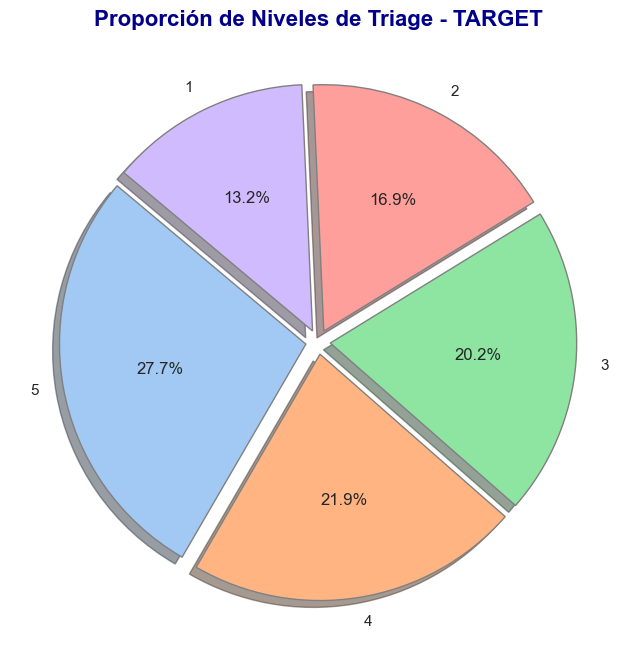

In [12]:
# Contar la cantidad de ocurrencias de cada nivel de triage
nivel_triage_counts = df_triage['nivel_triage'].value_counts()

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el gráfico circular mejorado
plt.figure(figsize=(10, 8))

# Definir colores pastel
colors = sns.color_palette("pastel")

# Crear el gráfico circular con mejoras
plt.pie(
    nivel_triage_counts,
    labels=nivel_triage_counts.index,  # Usar solo los números originales como etiquetas
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'gray', 'linewidth': 1},
    explode=[0.05] * len(nivel_triage_counts),  # Separar las porciones
    shadow=True  # Añadir sombras
)

# Título mejorado
plt.title('Proporción de Niveles de Triage - TARGET', fontsize=16, weight='bold', color='darkblue')

# Mostrar el gráfico
plt.show()


Distribución de clases:
 nivel_triage
5    155452
4    122839
3    113390
2     94850
1     73955
Name: count, dtype: int64
Razón de clase mayoritaria a clase minoritaria: 2.10


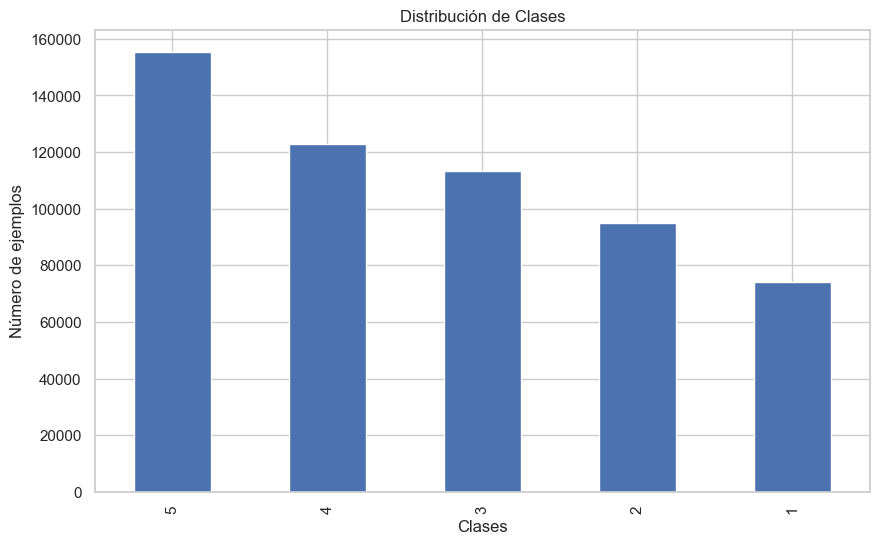

In [13]:
# Verificar la distribución de clases de la variable target
target_col = 'nivel_triage'  # Reemplaza con el nombre de tu variable target
class_distribution = df_triage[target_col].value_counts()

# Imprimir la distribución de clases
print("Distribución de clases:\n", class_distribution)

# Calcular la razón de clase mayoritaria a clase minoritaria
class_ratio = class_distribution.max() / class_distribution.min()
print(f"Razón de clase mayoritaria a clase minoritaria: {class_ratio:.2f}")

# Visualizar la distribución de clases
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Distribución de Clases')
plt.xlabel('Clases')
plt.ylabel('Número de ejemplos')
plt.show()


C:\Users\Administrador\AppData\Local\Temp\ipykernel_17924\3030021575.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x='modo_llegada', palette='pastel')


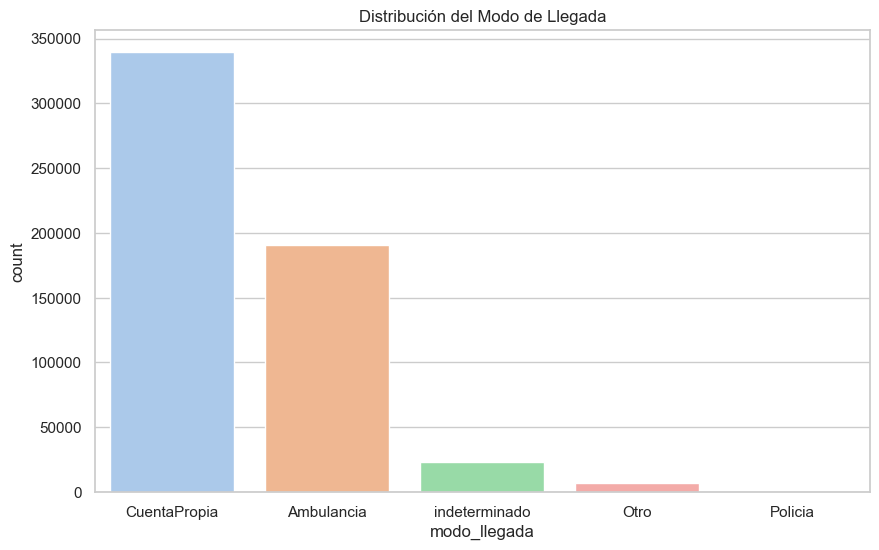

C:\Users\Administrador\AppData\Local\Temp\ipykernel_17924\3030021575.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x='mes', palette='pastel', order=mes_order)


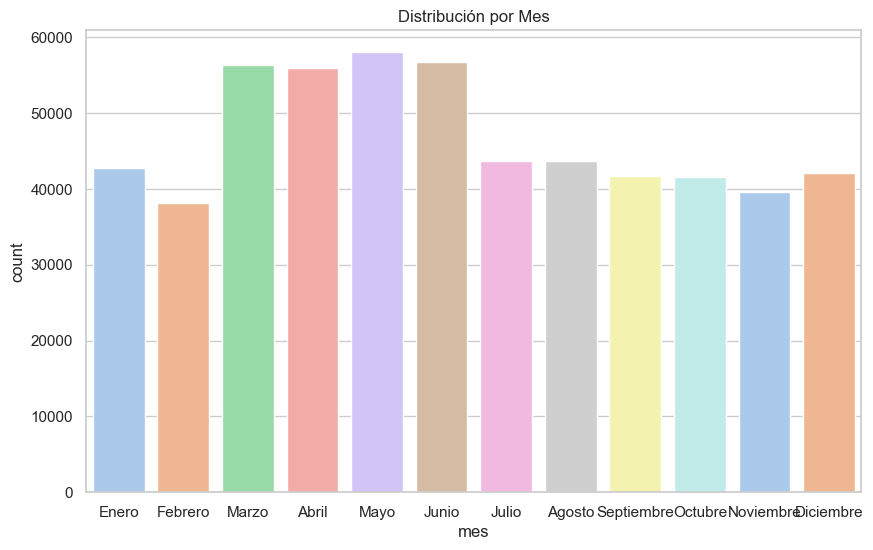

C:\Users\Administrador\AppData\Local\Temp\ipykernel_17924\3030021575.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x='dia', palette='pastel', order=dia_order)


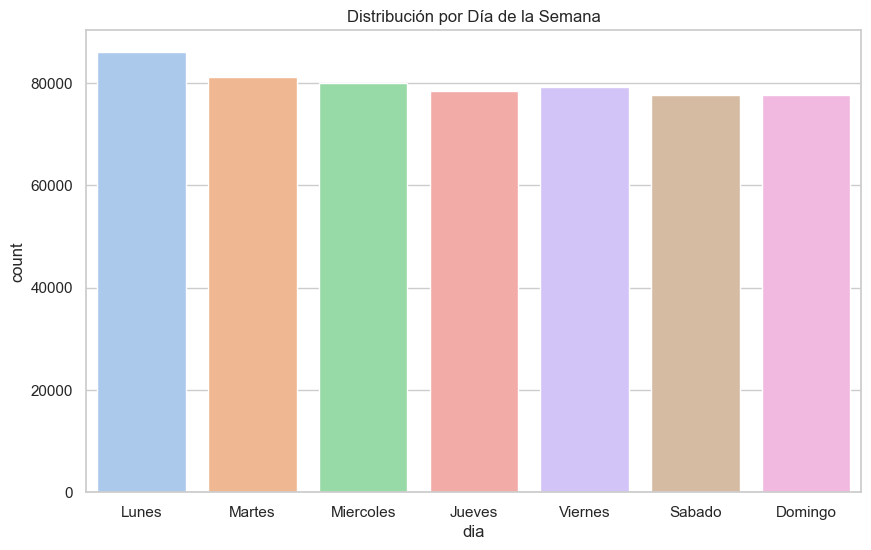

C:\Users\Administrador\AppData\Local\Temp\ipykernel_17924\3030021575.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x='llegada_hora_bin', palette='pastel')


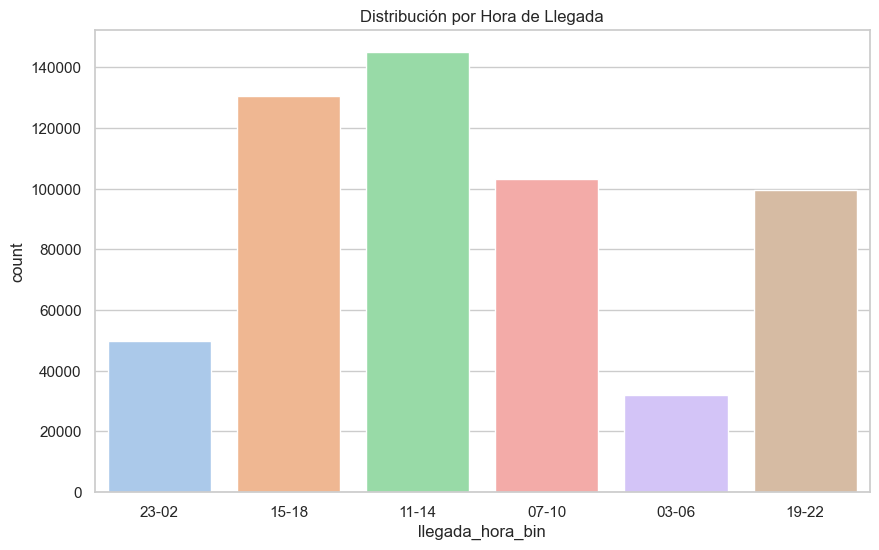

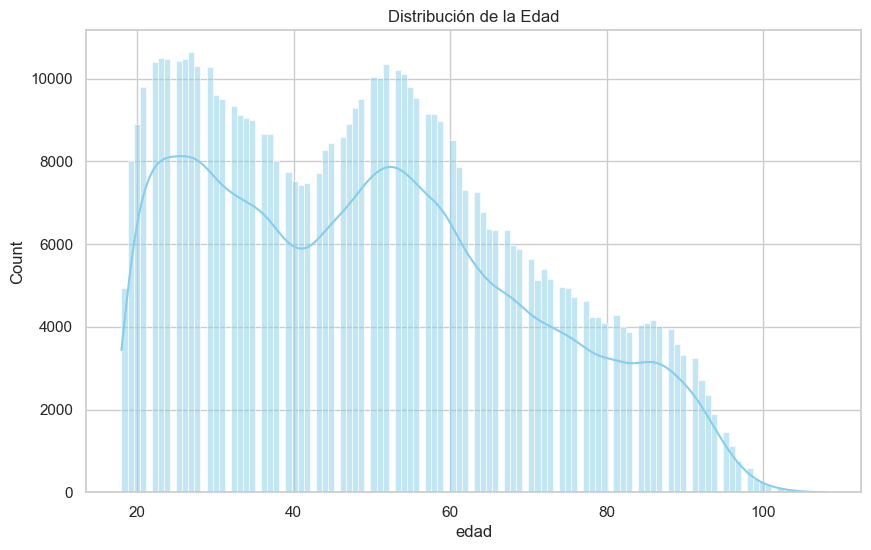

C:\Users\Administrador\AppData\Local\Temp\ipykernel_17924\3030021575.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x='TipoCobertura', palette='pastel')


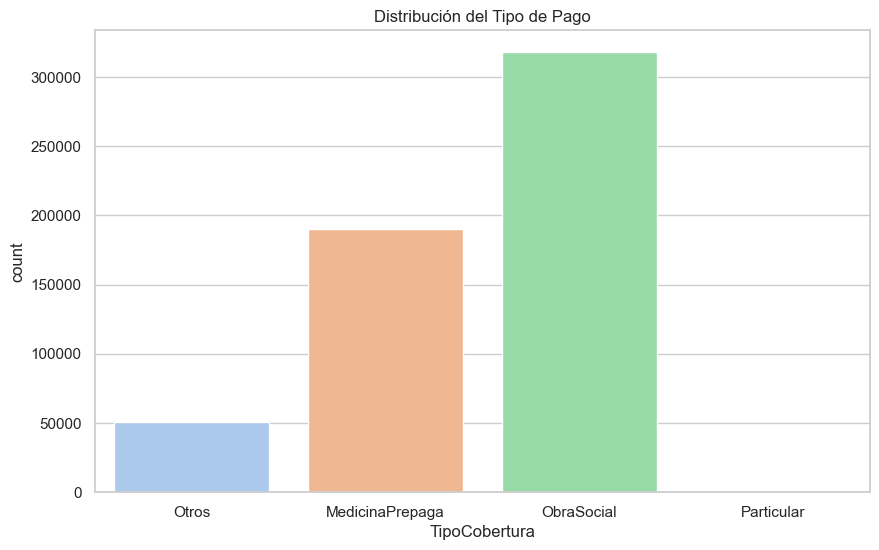

C:\Users\Administrador\AppData\Local\Temp\ipykernel_17924\3030021575.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x='genero', palette='pastel')


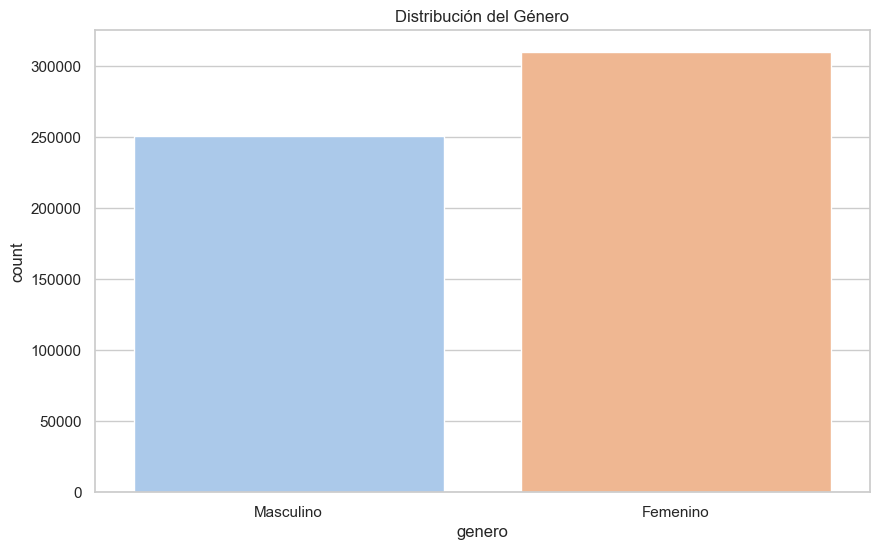

In [14]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Distribución de 'modo_llegada'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_triage, x='modo_llegada', palette='pastel')
plt.title('Distribución del Modo de Llegada')
plt.show()

# Definir el orden de los meses
mes_order = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Convertir la columna 'mes' a una categoría ordenada
df_triage['mes'] = pd.Categorical(df_triage['mes'], categories=mes_order, ordered=True)

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de distribución por mes ordenado
plt.figure(figsize=(10, 6))
sns.countplot(data=df_triage, x='mes', palette='pastel', order=mes_order)
plt.title('Distribución por Mes')
plt.show()

# Definir el orden de los días de la semana
dia_order = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']

# Convertir la columna 'dia' a una categoría ordenada
#df_triage['dia'] = pd.Categorical(df_triage['dia'], categories=dia_order, ordered=True)

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de distribución por día ordenado
plt.figure(figsize=(10, 6))
sns.countplot(data=df_triage, x='dia', palette='pastel', order=dia_order)
plt.title('Distribución por Día de la Semana')
plt.show()

# Distribución de 'hora_llegada'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_triage, x='llegada_hora_bin', palette='pastel')
plt.title('Distribución por Hora de Llegada')
plt.show()

# Distribución de 'edad'
plt.figure(figsize=(10, 6))
sns.histplot(df_triage['edad'], kde=True, color='skyblue')
plt.title('Distribución de la Edad')
plt.show()

# Distribución de 'tipodepago'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_triage, x='TipoCobertura', palette='pastel')
plt.title('Distribución del Tipo de Pago')
plt.show()

# Distribución de 'genero'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_triage, x='genero', palette='pastel')
plt.title('Distribución del Género')
plt.show()

In [15]:
#columnas dolencias
dolencias = ['cc_abdominalcramping','cc_distension_abdominal','cc_dolorabdominal','cc_dolorabdominalembarazada','cc_abnormallab','cc_absceso','problema_de_adiccion_cc','cc_agitacion','cc_alcoholintoxicacion','cc_problemaalcohol','cc_reaccionalergica','cc_alteredmentalstatus','cc_animalbite','cc_lesiondetobillo','cc_dolor_tobillo','cc_ansiedad','cc_lesion_brazo','cc_dolor_brazo','cc_hinchazon_brazo','cc_victima_agresion','cc_asma','cc_dolor_espalda','cc_sangrado_moretones','cc_borrosavision','cc_exposicion_fluidos_corporales','cc_dolor_de_pecho','cc_dificultad_respiratoria','cc_problema_de_respiracion','cc_quemadura','cc_paro_cardiaco','cc_celulitis','cc_dolor_pecho','cc_opresion_pecho','cc_escalofrios','cc_resfrio','cc_confusion','cc_conjuntivitis','cc_estrenimiento','cc_tos','cc_quiste','cc_disminucion_del_azucar_en_la_sangre-sintomatico','cc_deshidratacion','cc_dolor_dental','cc_depresion','cc_desintoxicacion','cc_diarrea','cc_mareos','cc_evaluacion_adiccion','cc_problemadedrogas','cc_disnea','cc_disuria','cc_dolor_oido','problema_cc_oido','cc_edema','cc_dolor_codo','cc_azucar_sangre_asintomatico','cc_azucar_sangre_sintomatico','cc_emesis','cc_dolorepigastrico','cc_epistaxis','cc_exposicion_ETS','cc_laceracion_extremidad','cc_extremidaddebilidad','cc_lesion_ocular','cc_dolor_ojos','cc_problema_ocular','cc_enrojecimiento_ojos','cc_lesion_facial','cc_laceracion_facial','cc_dolor_facial','cc_hinchazon_facial','cc_caida','cc_caida_mas_65','cc_fatiga','cc_problema_femenino','fiebre_cc','cc_fiebre_mas_75','cc_fiebre_9a74','cc_fiebre_inmunodepresion','cc_lesiondedos','cc_dolordedos','cc_hinchazon_dedos','cc_dolor_flanco','cc_seguimiento-celulitis','cc_injuriadelpie','cc_dolor_pie','cc_hinchazon_pie','cc_cuerpo_extraño_en_ojo','cc_trauma_total','cc_dolores_generalizados','cc_sangrado_gastrico','problema_cc_gi','cc_dolor_ingle','cc_alucinaciones','cc_lesion_mano','cc_dolor_mano','dolor_de_cabeza_cc','cc_dolor_cabeza_nuevos_sintomas','cc_dolor_cabeza_recurrente','cc_dolor_cabeza_evaluacion','cc_lesion_cabeza','cc_laceracion_cabeza','cc_hematuria','cc_hemoptisis','cc_dolor_cadera','cc_homicida','cc_hiperglucemia','cc_hipertension','cc_hipotension','cc_influenza','cc_ingestion','cc_picadura_insecto','cc_latidoirregular','cc_dolor_mandibula','cc_hinchazon_de_las_articulaciones','cc_lesionderodilla','cc_rodilla','cc_laceracion','cc_lesion_pierna','cc_dolor_pierna','cc_hinchazon_pierna','cc_letargo','cc_perdida_conocimiento','cc_maleguproblema','cc_masa','cc_problemamedico','cc_examen_medico','cc_problemademedicamento','cc_recargademedicamento','cc_migrana','cc_modificadotrauma','cc_accidente_automovilistico','cc_maccidente_motocicleta','cc_caidas_multiples','cc_congestion_nasal','cc_nauseas','cc_sincope','cc_dolor_cuello','cc_problemaneurologico','cc_entumecimiento','cc_hinchazon_bucal','cc_otalgia','cc_otro','cc_sobredosis-accidental','cc_sobredosis-intencional','cc_dolor','cc_palpitaciones','cc_ataque_panico','cc_dolor_pelvico','envenenamiento_cc','cc_post-opproblema','cc_evaluacion_psiquitatrica','sintomas_psicoticos','cc_erupcion','cc_sangradorectal','cc_dolor_rectal','cc_distressrespiratorio','cc_lesion_costillas','cc_dolor_costillas','cc_convulsiones_nuevo','cc_convulciones_antecedentes','cc_convulsiones','cc_falta_de_aliento','cc_lesiondehombro','cc_dolor_de_hombro','cc_dolor_celulas_falciformes','problema_cc_sinusal','cc_irritacionde_la_piel','cc_problema_piel','cc_dolor_de_garganta','cc_control_estandar','cc_alerta_ACV','cc_suicida','cc_retiro_sutura','cc_cuerpo_extraño_ingerido','cc_sincope','cc_testiclepain','cc_thumbinjury','cc_tickremoval','cc_toeinjury','cc_toepain','cc_trauma','cc_unresponsive','cc_uri','cc_frecuenciaurinaria','cc_retencionurinaria','cc_infeccion_del_tracto_urinario','cc_sangradovaginal','cc_descargavaginal','cc_dolor_vaginal','cc_debilidad','cc_sibilancias','cc_retiro-alcohol','cc_verificacion_de_heridas','cc_infeccion_de_heridas','cc_evaluacion-herida','cc_lesiondemuneca','cc_dolor_de_muneca']

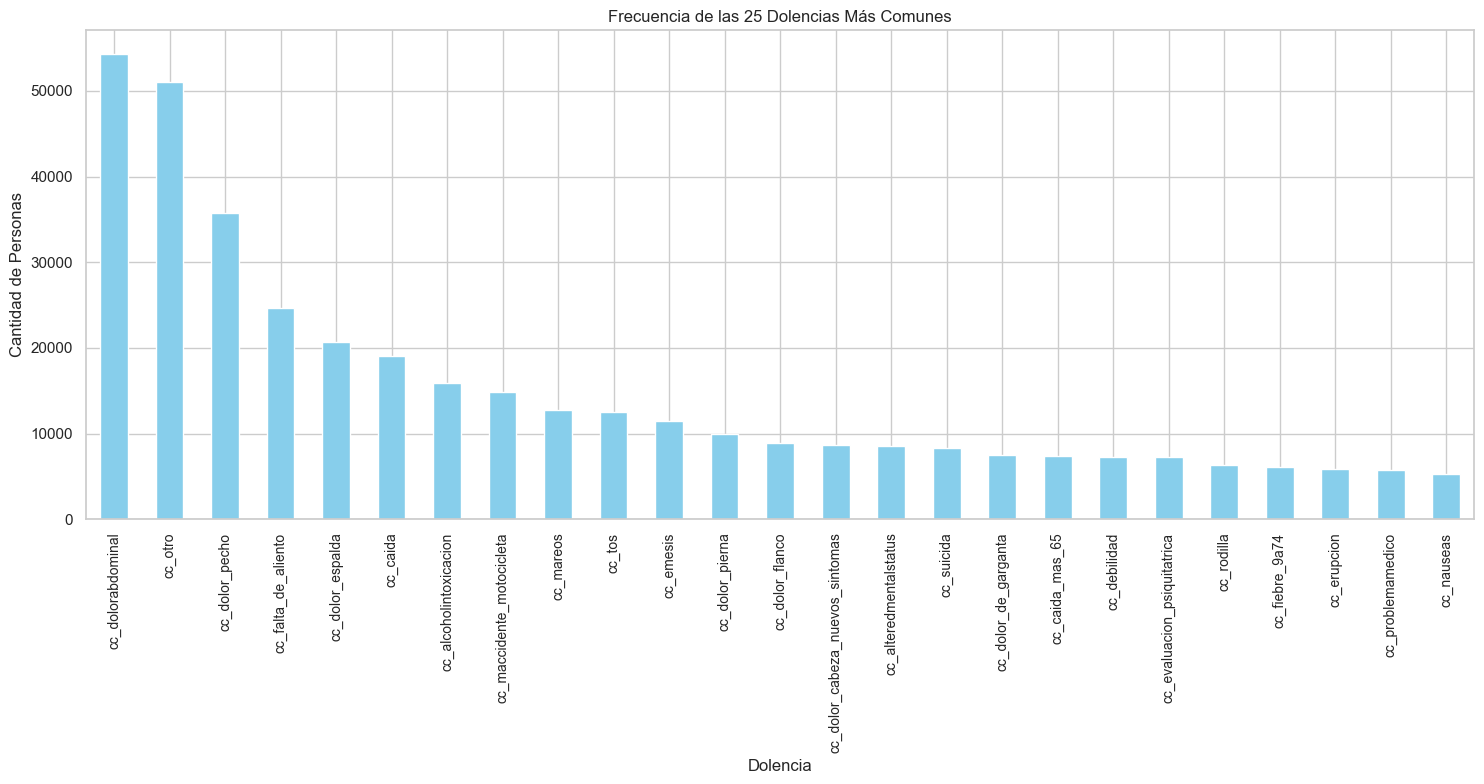

In [16]:
# Calcular la suma de cada columna booleana para obtener la cantidad de personas con cada dolencia
dolencia_counts = df_triage[dolencias].sum().sort_values(ascending=False)

# Seleccionar las 25 dolencias más frecuentes
top_25_dolencias = dolencia_counts.head(25)

# Graficar el histograma
plt.figure(figsize=(15, 8))
top_25_dolencias.plot(kind='bar', color='skyblue')
plt.title('Frecuencia de las 25 Dolencias Más Comunes')
plt.xlabel('Dolencia')
plt.ylabel('Cantidad de Personas')
plt.xticks(rotation=90, ha='center', fontsize=10)  # Rotar las etiquetas y ajustar el tamaño de la fuente
plt.tight_layout()  # Ajustar el layout para que las etiquetas no se corten
plt.show()

In [17]:
# Definir las columnas a codificar
columnas_a_codificar = ['modo_llegada', 'mes', 'dia', 'llegada_hora_bin', 'TipoCobertura','genero']

# Crear una instancia de OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' para evitar la multicolinealidad

# Aplicar OneHotEncoder a las columnas seleccionadas
encoded_columns = encoder.fit_transform(df_triage[columnas_a_codificar])

# Convertir el resultado en un DataFrame y agregar nombres a las columnas
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(columnas_a_codificar))

# Concatenar las columnas codificadas con el DataFrame original
df_triage_encoded = pd.concat([df_triage.drop(columns=columnas_a_codificar), encoded_df], axis=1)

# Revisar el DataFrame resultante
print(df_triage_encoded.head())

# Imprimir las primeras filas del DataFrame resultante para revisión
print(df_triage_encoded.head())

# Imprimir la cantidad de columnas después de la transformación
print(f"El DataFrame resultante tiene {df_triage_encoded.shape[1]} columnas.")


   Unnamed: 0  nivel_triage  edad  hernia_abdominal  dolor_abdominal  postaborto  deformidades_pie  insuficiencia_renal_aguda  cvd_agudo  infarto_agudo_miocardio  anemia_aguda_poshemorragica  alcoholismo  alergia  cavidad_amniotica  analrectal  anemia  aneurisma  ansiedad  apendicitis  artembolismo  neumonia_grave  asma  tdah  problema_espalda  biliar  nacimientoasfixia  trauma_nacimiento  cancer_vejiga  ceguera  cancer_hueso  hiperplasia_prostata  cancer_cerebral  cancer_mama  cancer_pulmon  bronquitis  quemaduras  paro_cardiaco  anomalias_cardiacas  carditis  catarata  cancer_cuello_utero  dolor_pecho  insuficiencia_cardiaca  renal  coagulacion_hemorragia  cancer_colon  coma_danocerebral  complicacion_implante  complicacion_medica  conduccion  epoc  artero_coronaria  apultimoamiento  fibrosis_quistica  trastornos_cognitivos  trastornos_desarrollo  diabetes_melitus_no_complicacion  diabetes_melitus_si_complicacion  divrticulos  mareo  diabetes_embarazo  arritmia  parto_prematuro  efec

In [18]:
# Función para rellenar NaN con la mediana de cada columna
def fill_na_with_median(df, columns):
    for col in columns:
        if df[col].isna().sum() > 0:  # Solo rellena si hay NaNs
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
    return df

variables_nan = ['triage_vital_hr','triage_vital_sbp','triage_vital_dbp','triage_vital_rr','triaje_vital_o2','triage_vital_temp','n_visita_urgencia','n_admisiones','n_cirugias','med_combinacion_analgesica_y_antihistaminica','med_analgesicos','med_anestesicos','med_anti-obesidad','med_antialergia','med_antiartriticos','med_antiasma','med_antibioticos','med_anticoagulantes','med_antidotos','med_antifungicos','med_combinacion_de_antihistaminico_y_descongestionante','med_antihistaminicos','med_antihiperglucemicos','med_antiinfecciosos','med_antiinfectives/varios','med_antineopultimoics','med_antiparkinsondrogas','med_antiplaquetarios','med_antivirales','med_autonomas','med_cardiacos','med_cardiovasculares','med_cns','med_anticonceptivos','med_diureticos','med_gastrointestinales','med_inmunosupresores','med_investigacional','med_relajantes_musculares','med_pre-natalvitaminas','med_psicoterapeuticos','med_sedantes/hipnoticos','med_vitaminas','cxr_cuenta','cuenta_echo','recuento_electrocardiograma','headct_cuenta','mri_cuenta','otroct_cuenta','otroimg_cuenta','otrosus_cuenta','otroxr_cuenta','edad','pulso_ultimo','resp_ultimo','spo2_ultimo','temp_ultimo','sbp_ultimo','dbp_ultimo','pulso_min','resp_min','spo2_min','temp_min','sbp_min','dbp_min','pulso_max','resp_max','spo2_max','temp_max','sbp_max','dbp_max','pulso_mediana','resp_mediana','spo2_mediana','sbp_mediana','dbp_mediana','cuenta_sangre','glucosaua_cuenta','leucocitosua_cuenta','nitriteua_cuenta','proteinua_cuenta','bloodcultureroutine_cuenta','urinecultureroutine_cuenta','absolutamentemphcitocuenta_ultimo','albumina_ultima','anc(absneutrophilcuenta)_ultimo','aniongap_ultimo','aspartatoaminotransferasa(ast)_ultimo','b-typenatriureticpeptidepro(probnp)_ultimo','bilirrubinadirect_ultimo','panecillo_ultimo','bollo/creatratio_ultimo','calcio_ultimo','cloruro_ultimo','creatinina_ultimo','dimero_d_ultimo','egfr_ultimo','glucosa_ultima','hematocrito_ultimo','hemoglobina_ultima','inr_ultimo','lactatepoc_ultimo','plaquetas_ultimo','potasio_ultimo','sodio_ultimo','troponini(poc)_ultimo','wbc_ultimo']

# Rellenar los NaN con la mediana en las columnas especificadas
df_triage_encoded = fill_na_with_median(df_triage_encoded, variables_nan)

# Verificar que los NaN han sido rellenados
print(df_triage_encoded[variables_nan].isna().sum())

C:\Users\Administrador\AppData\Local\Temp\ipykernel_17924\3883604347.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
C:\Users\Administrador\AppData\Local\Temp\ipykernel_17924\3883604347.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

triage_vital_hr                                           0
triage_vital_sbp                                          0
triage_vital_dbp                                          0
triage_vital_rr                                           0
triaje_vital_o2                                           0
triage_vital_temp                                         0
n_visita_urgencia                                         0
n_admisiones                                              0
n_cirugias                                                0
med_combinacion_analgesica_y_antihistaminica              0
med_analgesicos                                           0
med_anestesicos                                           0
med_anti-obesidad                                         0
med_antialergia                                           0
med_antiartriticos                                        0
med_antiasma                                              0
med_antibioticos                        

In [19]:
campos_outliers = ['triage_vital_hr','triage_vital_sbp','triage_vital_dbp','triage_vital_rr','triaje_vital_o2','triage_vital_temp','n_visita_urgencia','n_admisiones','n_cirugias','med_combinacion_analgesica_y_antihistaminica','med_analgesicos','med_anestesicos','med_anti-obesidad','med_antialergia','med_antiartriticos','med_antiasma','med_antibioticos','med_anticoagulantes','med_antidotos','med_antifungicos','med_combinacion_de_antihistaminico_y_descongestionante','med_antihistaminicos','med_antihiperglucemicos','med_antiinfecciosos','med_antiinfectives/varios','med_antineopultimoics','med_antiparkinsondrogas','med_antiplaquetarios','med_antivirales','med_autonomas','med_cardiacos','med_cardiovasculares','med_cns','med_anticonceptivos','med_diureticos','med_gastrointestinales','med_inmunosupresores','med_investigacional','med_relajantes_musculares','med_pre-natalvitaminas','med_psicoterapeuticos','med_sedantes/hipnoticos','med_vitaminas','cxr_cuenta','cuenta_echo','recuento_electrocardiograma','headct_cuenta','mri_cuenta','otroct_cuenta','otroimg_cuenta','otrosus_cuenta','otroxr_cuenta','edad','pulso_ultimo','resp_ultimo','spo2_ultimo','temp_ultimo','sbp_ultimo','dbp_ultimo','pulso_min','resp_min','spo2_min','temp_min','sbp_min','dbp_min','pulso_max','resp_max','spo2_max','temp_max','sbp_max','dbp_max','pulso_mediana','resp_mediana','spo2_mediana','sbp_mediana','dbp_mediana','cuenta_sangre','glucosaua_cuenta','leucocitosua_cuenta','nitriteua_cuenta','proteinua_cuenta','bloodcultureroutine_cuenta','urinecultureroutine_cuenta','absolutamentemphcitocuenta_ultimo','albumina_ultima','anc(absneutrophilcuenta)_ultimo','aniongap_ultimo','aspartatoaminotransferasa(ast)_ultimo','b-typenatriureticpeptidepro(probnp)_ultimo','bilirrubinadirect_ultimo','panecillo_ultimo','bollo/creatratio_ultimo','calcio_ultimo','cloruro_ultimo','creatinina_ultimo','dimero_d_ultimo','egfr_ultimo','glucosa_ultima','hematocrito_ultimo','hemoglobina_ultima','inr_ultimo','lactatepoc_ultimo','plaquetas_ultimo','potasio_ultimo','sodio_ultimo','troponini(poc)_ultimo','wbc_ultimo']
#campos_a_analizar = df_triage_campos_outliers  
# Aplicar Isolation Forest
iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', random_state=42)
df_triage_encoded['outliers'] = iso_forest.fit_predict(df_triage_encoded[campos_outliers])

# Filtrar los outliers detectados
outliers = df_triage_encoded[df_triage_encoded['outliers'] == -1]

# Calcular el porcentaje de outliers
total_rows = len(df_triage_encoded)
num_outliers = len(outliers)
percentage_outliers = (num_outliers / total_rows) * 100

# Mostrar resultados
print(f"Total de datos: {total_rows}")
print(f"Número de outliers detectados: {num_outliers}")
print(f"Porcentaje de outliers: {percentage_outliers:.2f}%")

# Interpretación de los resultados
threshold = 5  # Umbral del 5% por ejemplo

if percentage_outliers > threshold:
    print("El porcentaje de outliers es alto, lo que podría indicar que los datos están distorsionados.")
else:
    print("El porcentaje de outliers es bajo, probablemente no afecta significativamente el análisis.")

Total de datos: 560486
Número de outliers detectados: 16004
Porcentaje de outliers: 2.86%
El porcentaje de outliers es bajo, probablemente no afecta significativamente el análisis.


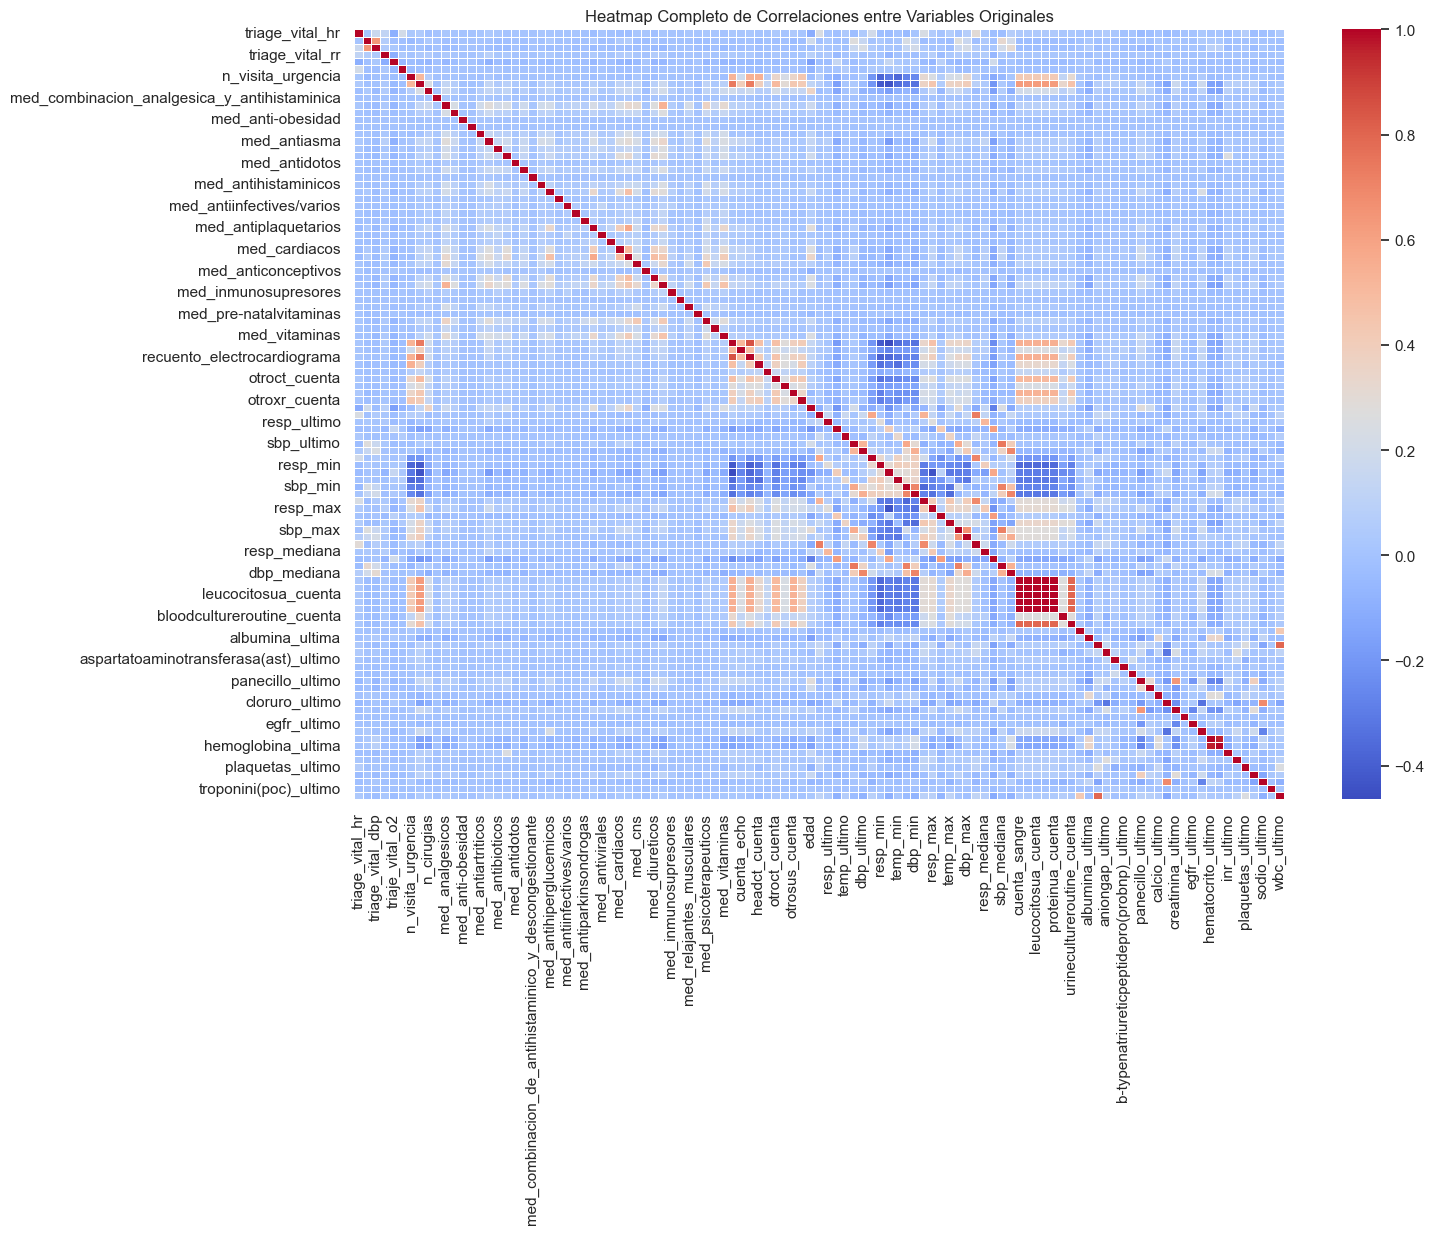

In [20]:
# 1. Calcular la matriz de correlación de las variables originales
correlation_matrix_original = df_triage_encoded[campos_outliers].corr()

# 2. Visualizar usando un heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix_original, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Completo de Correlaciones entre Variables Originales')
plt.show()


In [32]:
from scipy.stats import f_oneway
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Convert to Pandas
data_pandas = pd.DataFrame(df_triage_encoded)

# Identify columns
numerical_cols = list(data_pandas.select_dtypes(include=['int64', 'float64']).columns)
target_column = 'nivel_triage'

# Exclude the target column from numerical_cols
numerical_cols = [col for col in numerical_cols if col != target_column]

# Convert float64 and int64 to float32
data_pandas[numerical_cols] = data_pandas[numerical_cols].astype(np.float32)

# Impute and scale
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Imputed and scaled data
X_imputed = imputer.fit_transform(data_pandas[numerical_cols]).astype(np.float32)  # Ensure float32
X_scaled = scaler.fit_transform(X_imputed).astype(np.float32)  # Ensure float32

# Calcula F-Score para cada feature respecto al target categórico
anova_results = {}
for feature in numerical_cols:  # Itera sobre los nombres de las columnas
    groups = [data_pandas[feature][data_pandas[target_column] == category] for category in data_pandas[target_column].unique()]
    f_score, p_value = f_oneway(*groups)
    anova_results[feature] = {'F-Score': f_score, 'p-value': p_value}

# Convierte los resultados a DataFrame
anova_df = pd.DataFrame(anova_results).T.sort_values(by='F-Score', ascending=False)
anova_df.index.name = 'Feature'  # Agrega un nombre para el índice

# Mostrar las 10 mejores variables
print(anova_df.head(10))

# Exportar resultados
destination_path = 'anova_results_corrected.csv'
anova_df.to_csv(destination_path, index=True)
print(f"Resultados ANOVA exportados a {destination_path}")


# Exportar resultados
anova_df.to_csv('anova_results.csv', index=True)




                                 F-Score  p-value
Feature                                          
modo_llegada_CuentaPropia   14847.431935      0.0
edad                        11879.115145      0.0
modo_llegada_indeterminado  11000.106641      0.0
cc_dolorabdominal           10880.962223      0.0
med_cardiovasculares         7138.952050      0.0
hipertension                 6533.613079      0.0
cc_alcoholintoxicacion       6506.720628      0.0
spo2_min                     6443.978541      0.0
med_gastrointestinales       5696.309253      0.0
n_admisiones                 5023.565477      0.0
Resultados ANOVA exportados a anova_results_corrected.csv


c:\Users\Administrador\Documents\Python Scripts\Tesis\tesisaustral\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


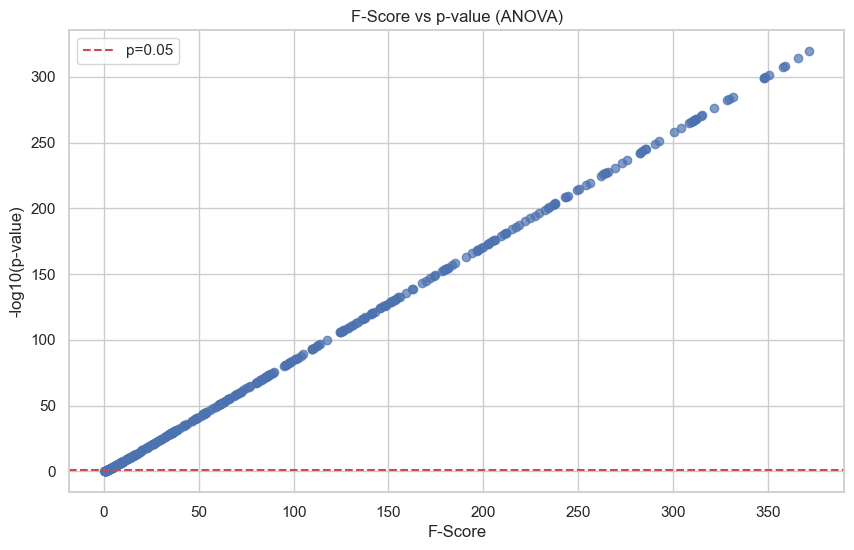

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(anova_df['F-Score'], -np.log10(anova_df['p-value']), alpha=0.7)
plt.xlabel('F-Score')
plt.ylabel('-log10(p-value)')
plt.title('F-Score vs p-value (ANOVA)')
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')
plt.legend()
plt.show()


In [34]:
# Transformar el target categórico a números
data_pandas['target_encoded'] = data_pandas[target_column].astype('category').cat.codes

# Calcular correlación de Pearson
correlations = data_pandas[numerical_cols].corrwith(data_pandas['target_encoded'])

# Ordenar las variables por correlación
correlation_df = correlations.abs().sort_values(ascending=False).to_frame(name='Pearson Correlation')
print(correlation_df.head(10))

# Exportar resultados
correlation_df.to_csv('pearson_correlation_results.csv')



C:\Users\Administrador\AppData\Local\Temp\ipykernel_17924\1808271744.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_pandas['target_encoded'] = data_pandas[target_column].astype('category').cat.codes


                             Pearson Correlation
modo_llegada_CuentaPropia               0.290440
edad                                    0.262320
o2_dispositivo_max                      0.247506
med_cardiovasculares                    0.210684
triage_vital_o2_dispositivo             0.203445
spo2_min                                0.199653
modo_llegada_indeterminado              0.199004
hipertension                            0.196028
med_gastrointestinales                  0.188011
cc_alcoholintoxicacion                  0.177417


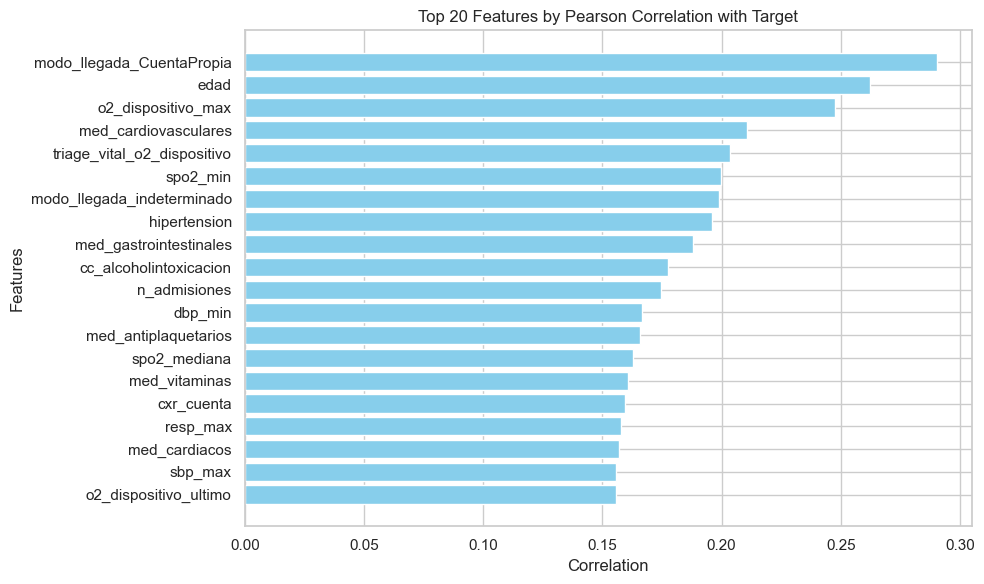

In [35]:
# Barplot de las correlaciones más altas
top_correlations = correlation_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_correlations.index, top_correlations['Pearson Correlation'], color='skyblue')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.title('Top 20 Features by Pearson Correlation with Target')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [22]:
df_triage_encoded.to_parquet('../tesisaustral/01_df_triage_encoded', index=False)
